In [7]:
# Load dataset
import pandas as pd

df = pd.read_csv("./IMDB-Dataset.csv")

# Remove duplicate rows
df = df.drop_duplicates()
print(df["review"].head())

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object


In [ ]:
# Load dataset
import pandas as pd

df = pd.read_csv("./IMDB-Dataset.csv")

# Remove duplicate rows
df = df.drop_duplicates()

# Import libraries for data cleaning
import re
import string
import nltk

nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words("english"))


# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)


# Function to clean data
def preprocess_text(text):
    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text, "html.parser")  # Removing html tags

    text = soup.get_text()
    text = expand_contractions(text)  # Expanding contractions

    # Removing emojis and special symbols
    emoji_clean = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    text = emoji_clean.sub(r"", text)

    text = re.sub(r"\.(?=\S)", ". ", text)  # Add space after full stop
    text = re.sub(r"http\S+", "", text)  # Remove URLs

    # Remove punctuation, stopwords, and lowercase the text
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    text = " ".join(
        [
            wl.lemmatize(word)
            for word in text.split()
            if word not in stop and word.isalpha()
        ]
    )

    return text


df["review"] = df["review"].apply(preprocess_text)
print(df["review"].head())

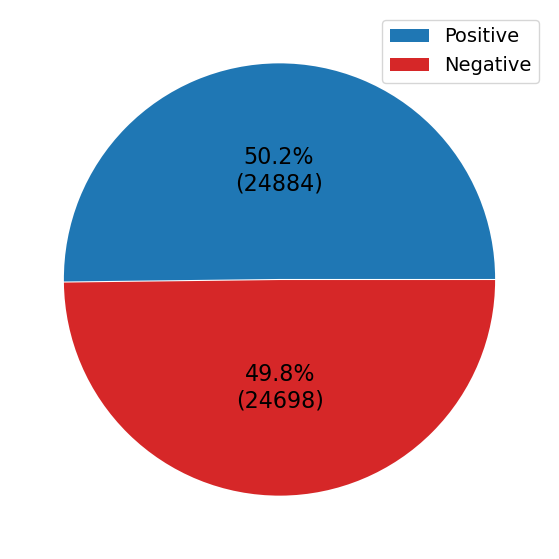

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Creating autopt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.0 * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)


freq_pos = len(df[df["sentiment"] == "positive"])
freq_neg = len(df[df["sentiment"] == "negative"])

data = [freq_pos, freq_neg]

labels = ["positive", "negative"]

# Create pie chart
pie, ax = plt.subplots(figsize=[11, 7])
plt.pie(
    x=data,
    autopct=lambda pct: func(pct, data),
    explode=[0.0025] * 2,
    pctdistance=0.5,
    colors=[sns.color_palette()[0], "tab:red"],
    textprops={"fontsize": 16},
)

# plt.title('Frequencies of sentiment labels', fontsize=14, fontweight='bold')
labels = [r"Positive", r"Negative"]
plt.legend(labels, loc="best", prop={"size": 14})
plt.savefig("PieChart.png")
plt.show()

/Users/nguyenvu/dev/Anaconda/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


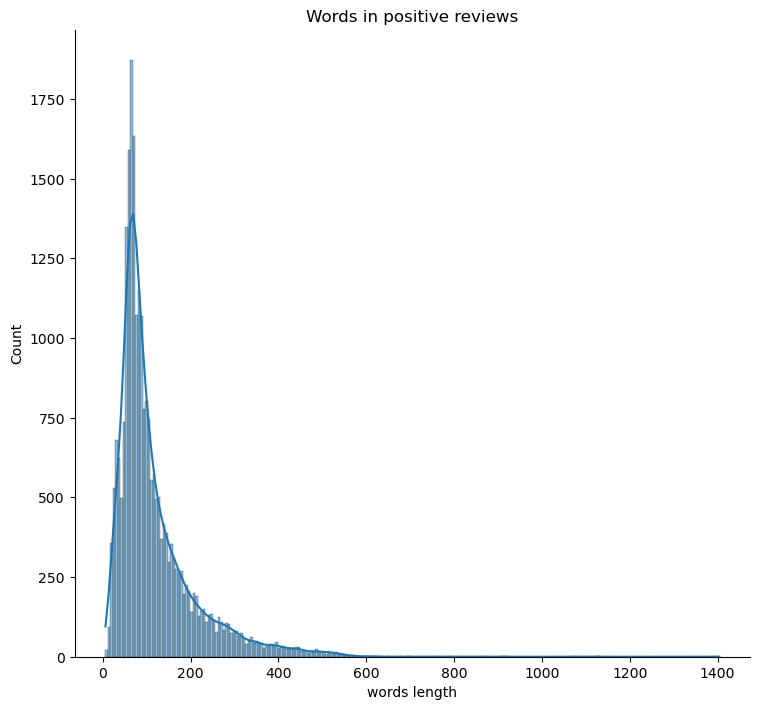

/Users/nguyenvu/dev/Anaconda/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


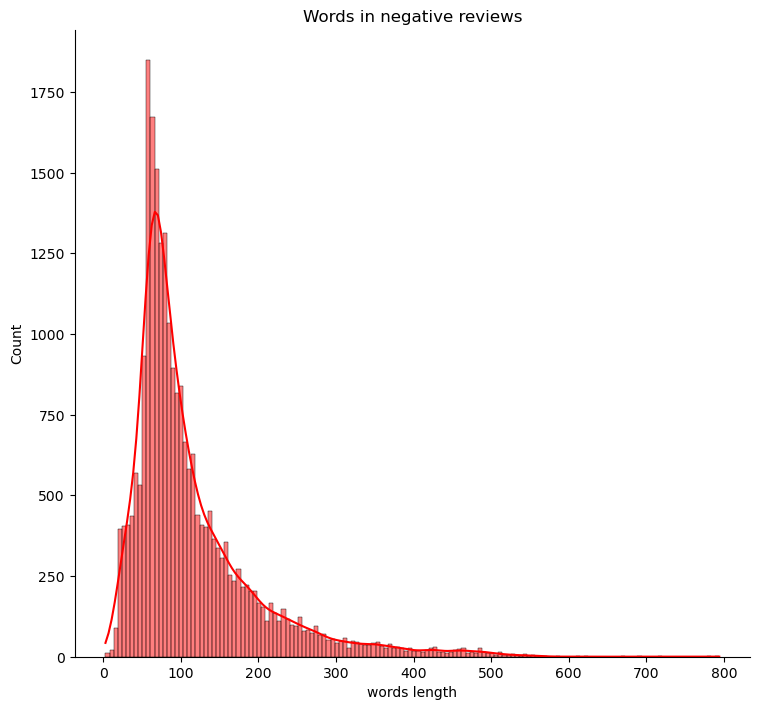

/Users/nguyenvu/dev/Anaconda/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


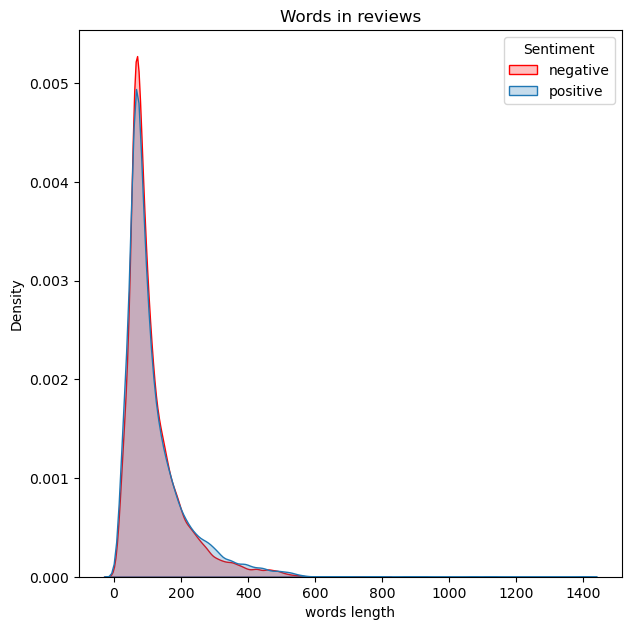

In [10]:
words_len = df["review"].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp["words length"] = words_len

hist_positive = sns.displot(
    data=df_temp[df_temp["sentiment"] == "positive"],
    x="words length",
    hue="sentiment",
    kde=True,
    height=7,
    aspect=1.1,
    legend=False,
).set(title="Words in positive reviews")
plt.show(hist_positive)

hist_negative = sns.displot(
    data=df_temp[df_temp["sentiment"] == "negative"],
    x="words length",
    hue="sentiment",
    kde=True,
    height=7,
    aspect=1.1,
    legend=False,
    palette=["red"],
).set(title="Words in negative reviews")
plt.show(hist_negative)

plt.figure(figsize=(7, 7.1))
kernel_distibution_number_words_plot = sns.kdeplot(
    data=df_temp,
    x="words length",
    hue="sentiment",
    fill=True,
    palette=[sns.color_palette()[0], "red"],
).set(title="Words in reviews")
plt.legend(title="Sentiment", labels=["negative", "positive"])
plt.show(kernel_distibution_number_words_plot)

In [13]:
# 4. Split train and test sets
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

x_data = df["review"]

label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df["sentiment"])

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

In [14]:
# 5. Vectorize text data
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

In [15]:
# 6. Train and evaluate model
# DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(criterion="entropy", random_state=42)

dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.7180598971463145

In [16]:
# RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.8427952001613391